# Variational Autoencoder Notebook
This notebook is reference to the original paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) and [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)  

###Necessary library and corresponding version:  
numpy version:  1.18.5  
pytorch version:  1.7.0+cu101  
torchvision version:  0.8.1+cu101  
matplotlib version:  3.2.2

In [ ]:
# Import necessary library

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Package requirement

print('numpy version: ', np.__version__)
print('pytorch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)
print('matplotlib version: ', matplotlib.__version__)

numpy version:  1.18.5
pytorch version:  1.7.0+cu101
torchvision version:  0.8.1+cu101
matplotlib version:  3.2.2


In [ ]:
# Set random seed for reproductibility

seed = 42
torch.manual_seed(seed)

# Data Preparation

In [ ]:
# Load PyTorch MNIST dataset

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, download=True,
    transform=transform
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Load data and separate into train and validation set in 5:1 ratio

train, val = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 64, shuffle = True)

# Variational Autoencoder model

In [ ]:
# Create Autoencoder class

class VAEs(nn.Module):
  def __init__(self, input_shape):
    super(VAEs, self).__init__()
    
    self.enc1 = nn.Linear(in_features=input_shape, out_features=256)
    self.enc2 = nn.Linear(in_features=256, out_features=128)
    self.enc3 = nn.Linear(in_features=128, out_features=64)
    self.enc4 = nn.Linear(in_features=64, out_features=32)
    self.enc5_mu = nn.Linear(in_features=32, out_features=16)
    self.enc5_std = nn.Linear(in_features=32, out_features=16)

    self.dec1 = nn.Linear(in_features=16, out_features=32)
    self.dec2 = nn.Linear(in_features=32, out_features=64)
    self.dec3 = nn.Linear(in_features=64, out_features=128)
    self.dec4 = nn.Linear(in_features=128, out_features=256)
    self.dec5 = nn.Linear(in_features=256, out_features=input_shape)
    """ 
    self.enc1 = nn.Linear(in_features=input_shape, out_features=400)
    self.enc2 = nn.Linear(in_features=400, out_features=200)
    self.enc3_mu = nn.Linear(in_features=200, out_features=20)
    self.enc3_std = nn.Linear(in_features=200, out_features=20)

    self.dec1 = nn.Linear(in_features=20, out_features=200)
    self.dec2 = nn.Linear(in_features=200, out_features=400)
    self.dec3 = nn.Linear(in_features=400, out_features=input_shape)
    """
  def forward(self, x):

    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = F.relu(self.enc4(x))
    x_mu = F.relu(self.enc5_mu(x))
    x_std = F.relu(self.enc5_std(x))

    x = self.reparameterization(x_mu, x_std)
    x = F.relu(self.dec1(x))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    #out = F.sigmoid(self.dec5(x))
    out = F.relu(self.dec5(x))

    return out, x_mu, x_std

  def reparameterization(self, x_mu, x_std):

    z_sample = torch.normal(mean=torch.zeros(x_mu.shape[0], 16), std=torch.ones(x_mu.shape[0], 16))
    #z_sample.mul(x_std)
    #z_sample.add(x_mu)
    std = x_std.mul(0.5).exp()
    z_sample.mul_(std).add_(x_mu)


    return z_sample

def total_loss(input, output, x_mu, x_std):

  #reconstruction_loss = F.binary_cross_entropy(input=output, target=input)
  reconstruction_loss = F.mse_loss(output, input)

  #KL_loss = 0.5 * torch.sum(x_mu.pow(2) + x_std.pow(2) - x_std.log() - 1) / x_mu.shape[0]
  dkl = - 0.5 * torch.sum(1 + x_std - x_mu.pow(2) - x_std.exp())
  dkl /= x_mu.shape[0]
  dkl /= 784

  #return reconstruction_loss + KL_loss
  return reconstruction_loss + dkl

In [ ]:
# Create the model instance

model = VAEs(784)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

VAEs(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5_mu): Linear(in_features=32, out_features=16, bias=True)
  (enc5_std): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)

# Training Process

In [ ]:
# Training

epoch = 20
train_loss = []
val_loss = []
for e in range(epoch):
  running_loss = 0
  for data in train_loader:
    x, _ = data
    x = x.view(-1, 784)
    optimizer.zero_grad()
    out, x_mu, x_std = model.forward(x)
    loss = total_loss(x, out, x_mu, x_std)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  ave_loss = running_loss / len(train_loader)
  train_loss.append(ave_loss)
  print('Train loss at {}/{} epoch is {}'.format(e+1, epoch, ave_loss))

  running_loss2 = 0
  for data in val_loader:
    input, _ = data
    out, x_mu, x_std = model.forward(x)
    loss = total_loss(x, out, x_mu, x_std)
    running_loss2 += loss.item()

  ave_loss2 = running_loss2 / len(val_loader)
  val_loss.append(ave_loss2)
  print('Val loss at {}/{} epoch is {}'.format(e+1, epoch, ave_loss2))

Train loss at 1/20 epoch is 0.07864429460614539
Val loss at 1/20 epoch is 0.07471336495534629
Train loss at 2/20 epoch is 0.07280188529273433
Val loss at 2/20 epoch is 0.07184419648093023
Train loss at 3/20 epoch is 0.07032082710996308
Val loss at 3/20 epoch is 0.0725568662023848
Train loss at 4/20 epoch is 0.06990277204100433
Val loss at 4/20 epoch is 0.068375919322679
Train loss at 5/20 epoch is 0.06865593233167211
Val loss at 5/20 epoch is 0.06483479200085257
Train loss at 6/20 epoch is 0.06740157031799521
Val loss at 6/20 epoch is 0.05469009750018454
Train loss at 7/20 epoch is 0.06555381867453418
Val loss at 7/20 epoch is 0.06688927503148462
Train loss at 8/20 epoch is 0.06549150010337458
Val loss at 8/20 epoch is 0.06970452441341558
Train loss at 9/20 epoch is 0.06536891301403112
Val loss at 9/20 epoch is 0.0655361533781905
Train loss at 10/20 epoch is 0.06475798184018763
Val loss at 10/20 epoch is 0.061491939150224065
Train loss at 11/20 epoch is 0.06448828673366543
Val loss at 

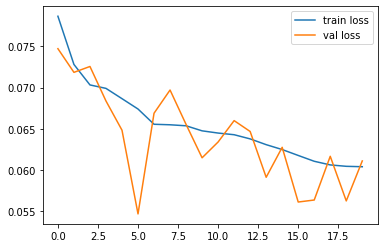

In [ ]:
# Plot out the train loss and validation loss versus epochs

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()

# Deploy the model to testing dataset

In [ ]:
# Prepare the testing dataset

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

# Input the test data into model and get the results
with torch.no_grad():
    test_examples, reconstruction = [], []
    for batch_features in test_loader:
        batch_features = batch_features[0]
        input_ = batch_features.view(-1, 784)
        output_, _, _ = model(input_)

        for n in range(len(input_)):
            test_examples.append(input_[n])
            reconstruction.append(output_[n])

# Create the reconstruction error array
err_arr = []
for i in range(len(test_examples)):
  err_arr.append(F.mse_loss(test_examples[i], reconstruction[i]))

err_arr = np.array(err_arr)

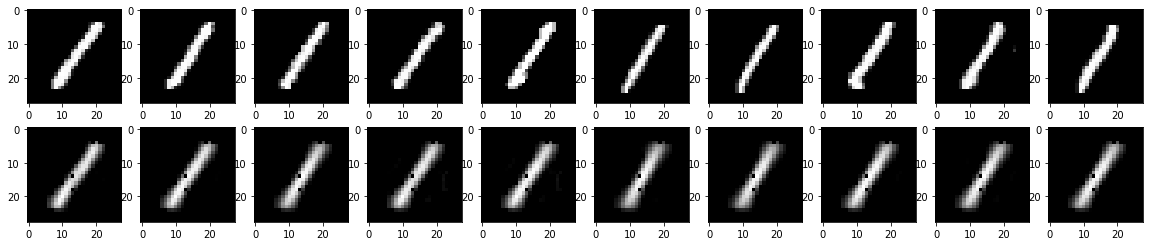

In [ ]:
# 10 images with lowest reconstruction error

plt.figure(figsize=(20, 4))

for n, index in enumerate(np.argsort(err_arr)[:10]):
    ax = plt.subplot(2, 10, n+1)
    ax.imshow(test_examples[index].numpy().reshape(28, 28), cmap = 'gray')

    ax = plt.subplot(2, 10, n+11)
    ax.imshow(reconstruction[index].numpy().reshape(28, 28), cmap = 'gray')

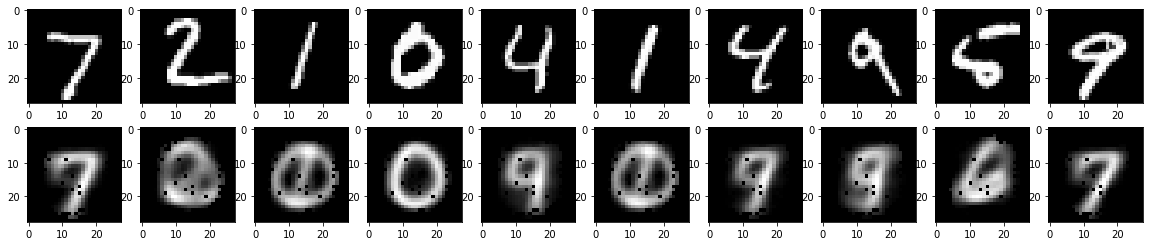

In [ ]:
# 10 images with highest reconstruction error

plt.figure(figsize=(20, 4))

for index in range(10):
  ax = plt.subplot(2, 10, index+1)
  ax.imshow(test_examples[index].numpy().reshape(28, 28), cmap = 'gray')

  ax = plt.subplot(2, 10, index+11)
  ax.imshow(reconstruction[index].numpy().reshape(28, 28), cmap = 'gray')